https://github.com/DataTalksClub/stock-markets-analytics-zoomcamp/blob/main/cohorts/2025/homework%202.md

In [1]:
import re
import gdown
import requests
from io import StringIO

In [2]:
import time
from datetime import date

In [3]:
from tqdm.notebook import tqdm

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import yfinance as yf

# Question 1: [IPO] Withdrawn IPOs by Company Type

What is the total withdrawn IPO value (in $ millions) for the company class with the highest total withdrawal value?

#### 1.1 Load the IPO withdrawal table into a DataFrame

In [6]:
url = 'https://stockanalysis.com/ipos/withdrawn/'

headers = {
    'User-Agent': (
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
        'AppleWebKit/537.36 (KHTML, like Gecko) '
        'Chrome/58.0.3029.110 Safari/537.3'
    )
}

response = requests.get(url, headers=headers, timeout=10)

html_io = StringIO(response.text)
tables = pd.read_html(html_io)

df = tables[0]
print(df.shape)
df.head()

(100, 4)


,Symbol,Company Name,Price Range,Shares Offered
0,ODTX,"Odyssey Therapeutics, Inc.",-,-
1,UNFL,"Unifoil Holdings, Inc.",$3.00 - $4.00,2000000
2,AURN,"Aurion Biotech, Inc.",-,-
3,ROTR,"PHI Group, Inc.",-,-
4,ONE,One Power Company,-,-


#### 1.2 Create a new column called Company Class, categorizing company names based on patterns like:
* “Acquisition Corp” or “Acquisition Corporation” → Acq.Corp
* “Inc” or “Incorporated” → Inc
* “Group” → Group
* “Ltd” or “Limited” → Limited
* “Holdings” → Holdings
* Others → Other

In [7]:
def get_company_class(s):
    ss = re.sub(r'[^a-zA-Z ]', '', s).lower().split()
    if 'acquisition' in ss and ('corp' in ss or 'corporation' in ss):
        return 'Acq.Corp'
    elif 'inc' in ss or 'incorporated' in ss:
        return 'Inc'
    elif 'group' in ss:
        return 'Group'
    elif 'ltd' in ss or 'limited' in ss:
        return 'Limited'
    elif 'holdings' in ss:
        return 'Holdings'
    else:
        return 'Other'

In [8]:
df['Company Class'] = df['Company Name'].apply(get_company_class)
df.head()

,Symbol,Company Name,Price Range,Shares Offered,Company Class
0,ODTX,"Odyssey Therapeutics, Inc.",-,-,Inc
1,UNFL,"Unifoil Holdings, Inc.",$3.00 - $4.00,2000000,Inc
2,AURN,"Aurion Biotech, Inc.",-,-,Inc
3,ROTR,"PHI Group, Inc.",-,-,Inc
4,ONE,One Power Company,-,-,Other


In [9]:
df['Company Class'].value_counts()

Company Class
Inc         51
Acq.Corp    21
Limited     17
Other        6
Group        4
Holdings     1
Name: count, dtype: int64

#### 1.3 Define a new field Avg. price by parsing the Price Range field 


In [10]:
def get_avg_price(s):
    ss = s.replace('$','').replace('-','').split()
    if len(ss) == 1:
        return float(ss[0])
    elif len(ss) == 2:
        return (float(ss[0]) + float(ss[1])) / 2
    return None    

In [11]:
df['Avg. price'] = df['Price Range'].apply(get_avg_price)
df.tail()

,Symbol,Company Name,Price Range,Shares Offered,Company Class,Avg. price
95,FHP,"Freehold Properties, Inc.",-,-,Inc,NaN
96,CHO,Chobani Inc.,-,-,Inc,NaN
97,IFIT,iFIT Health & Fitness Inc.,$18.00 - $21.00,30769231,Inc,19.5
98,GLGX,"Gerson Lehrman Group, Inc.",-,-,Inc,NaN
99,HCG,hear.com N.V.,$17.00 - $20.00,16220000,Other,18.5


#### 1.4 Convert Shares Offered to numeric, clean missing or invalid values.

In [12]:
df['Shares Offered'] = pd.to_numeric(df['Shares Offered'], errors='coerce')
df.tail()

,Symbol,Company Name,Price Range,Shares Offered,Company Class,Avg. price
95,FHP,"Freehold Properties, Inc.",-,NaN,Inc,NaN
96,CHO,Chobani Inc.,-,NaN,Inc,NaN
97,IFIT,iFIT Health & Fitness Inc.,$18.00 - $21.00,30769231.0,Inc,19.5
98,GLGX,"Gerson Lehrman Group, Inc.",-,NaN,Inc,NaN
99,HCG,hear.com N.V.,$17.00 - $20.00,16220000.0,Other,18.5


#### 1.5 Create a new column: Withdrawn Value = Shares Offered * Avg Price

In [13]:
df['Withdrawn Value'] = round(df['Shares Offered'] * df['Avg. price'] / 1_000_000,0)
df.tail()

,Symbol,Company Name,Price Range,Shares Offered,Company Class,Avg. price,Withdrawn Value
95,FHP,"Freehold Properties, Inc.",-,NaN,Inc,NaN,NaN
96,CHO,Chobani Inc.,-,NaN,Inc,NaN,NaN
97,IFIT,iFIT Health & Fitness Inc.,$18.00 - $21.00,30769231.0,Inc,19.5,600.0
98,GLGX,"Gerson Lehrman Group, Inc.",-,NaN,Inc,NaN,NaN
99,HCG,hear.com N.V.,$17.00 - $20.00,16220000.0,Other,18.5,300.0


#### 1.6 Group by Company Class and calculate total withdrawn value.

In [14]:
df.groupby('Company Class', as_index=False)['Withdrawn Value'].sum().sort_values('Withdrawn Value', ascending=False)

,Company Class,Withdrawn Value
0,Acq.Corp,4021.0
3,Inc,2259.0
5,Other,768.0
4,Limited,549.0
2,Holdings,75.0
1,Group,34.0


#### Question 1: Which class had the highest total value of withdrawals?
Ans: 4021 (Acq.Corp	)

# 2 [IPO] Median Sharpe Ratio for 2024 IPOs (First 5 Months)

The goal is to replicate the large-scale yfinance OHLCV data download and perform basic financial calculations on IPO stocks.

#### 2.1 Download the IPOs in 2024

In [15]:
url = 'https://stockanalysis.com/ipos/2024/'
response = requests.get(url, headers=headers, timeout=10)

html_io = StringIO(response.text)
tables = pd.read_html(html_io)

df = tables[0]
print(df.shape)
df.head()

(225, 6)


,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,"Dec 31, 2024",ONEG,OneConstruction Group Limited,$4.00,$5.00,25.00%
1,"Dec 27, 2024",PHH,"Park Ha Biological Technology Co., Ltd.",$4.00,$26.57,564.25%
2,"Dec 23, 2024",HIT,"Health In Tech, Inc.",$4.00,$0.62,-84.40%
3,"Dec 23, 2024",TDAC,Translational Development Acquisition Corp.,$10.00,$10.28,2.80%
4,"Dec 20, 2024",RANG,Range Capital Acquisition Corp.,$10.00,$10.21,2.10%


#### 2.2 Filter to keep only those IPOs before 1 June 2024 (first 5 months of 2024).

In [16]:
df['IPO Date'] = pd.to_datetime(df['IPO Date'])
df.head()

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,2024-12-31,ONEG,OneConstruction Group Limited,$4.00,$5.00,25.00%
1,2024-12-27,PHH,"Park Ha Biological Technology Co., Ltd.",$4.00,$26.57,564.25%
2,2024-12-23,HIT,"Health In Tech, Inc.",$4.00,$0.62,-84.40%
3,2024-12-23,TDAC,Translational Development Acquisition Corp.,$10.00,$10.28,2.80%
4,2024-12-20,RANG,Range Capital Acquisition Corp.,$10.00,$10.21,2.10%


In [17]:
df_filtered = df[df['IPO Date'] < '2024-06-01'].copy()
df_filtered = df_filtered[df_filtered['IPO Price'] != '-'].copy()
df_filtered.sort_values(by='IPO Date', inplace=True)
print(df_filtered.shape)
df_filtered.tail()

(75, 6)


,IPO Date,Symbol,Company Name,IPO Price,Current,Return
153,2024-05-15,RAY,Raytech Holding Limited,$4.00,$1.23,-69.25%
152,2024-05-15,JDZG,JIADE Limited,$4.00,$0.26,-93.40%
151,2024-05-17,RFAI,RF Acquisition Corp II,$10.00,$10.60,6.00%
150,2024-05-17,HDL,Super Hi International Holding Ltd.,$19.56,$18.70,-4.40%
149,2024-05-23,BOW,Bowhead Specialty Holdings Inc.,$17.00,$36.49,114.65%


#### 2.3 Download daily stock and Calculate the Sharpe ratio assuming a risk-free rate of 4.5%

In [18]:
ALL_TICKERS = df_filtered['Symbol'].values
ALL_TICKERS

array(['ROMA', 'SDHC', 'SYNX', 'PSBD', 'CCTG', 'KSPI', 'JVSA', 'SUGP',
       'JL', 'YIBO', 'CGON', 'BTSG', 'AVBP', 'HAO', 'FBLG', 'AS', 'GUTS',
       'ANRO', 'LEGT', 'AHR', 'KYTX', 'PMNT', 'TBBB', 'MGX', 'HLXB',
       'TELO', 'UMAC', 'CHRO', 'DYCQ', 'VHAI', 'SMXT', 'LGCL', 'RYDE',
       'INTJ', 'ALAB', 'LOBO', 'RDDT', 'BKHA', 'AUNA', 'IBAC', 'MMA',
       'BOLD', 'UBXG', 'ZBAO', 'MAMO', 'CTNM', 'MNDR', 'PACS', 'ULS',
       'TWG', 'MTEN', 'IBTA', 'CTRI', 'CDTG', 'TRSG', 'YYGH', 'MFI',
       'NCI', 'MRX', 'LOAR', 'RBRK', 'ZONE', 'VIK', 'CCIX', 'NNE', 'GPAT',
       'SVCO', 'PAL', 'ZK', 'BTOC', 'RAY', 'JDZG', 'RFAI', 'HDL', 'BOW'],
      dtype=object)

In [19]:
stocks_df = pd.DataFrame()

for ticker in tqdm(ALL_TICKERS):
    ticker_obj = yf.Ticker(ticker)
    historyPrices = ticker_obj.history(period = "max", interval = "1d")
    historyPrices['Ticker'] = ticker
    historyPrices['Date'] = historyPrices.index.date

    # historical returns
    for i in [1,3,7,30,90,252,365]:
        historyPrices['growth_'+str(i)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(i)

    historyPrices['volatility'] = historyPrices['Close'].rolling(30).std() * np.sqrt(252)

    time.sleep(1)

    stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)

  0%|          | 0/75 [00:00<?, ?it/s]

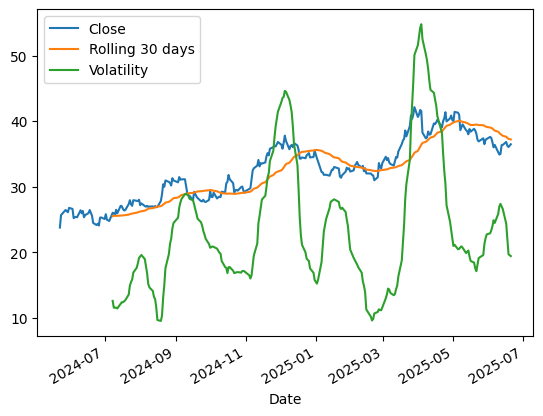

In [20]:
historyPrices['Close'].plot(label='Close')
historyPrices['Close'].rolling(30).mean().plot(label='Rolling 30 days')
historyPrices['volatility'].plot(label='Volatility')
plt.legend();

#### 2.4 Calculate the Sharpe ratio assuming a risk-free rate of 4.5%:

In [21]:
stocks_df['Sharpe'] = (stocks_df['growth_252d'] - 0.045) / stocks_df['volatility']
stocks_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Date,growth_1d,growth_3d,growth_7d,growth_30d,growth_90d,growth_252d,growth_365d,volatility,Sharpe
23316,36.360001,36.648998,36.080002,36.389999,176700,0.0,0.0,BOW,2025-06-13,1.000825,1.042096,0.989127,0.909750,1.094765,1.400693,NaN,26.618832,0.050930
23317,36.590000,37.042000,36.430000,36.840000,177700,0.0,0.0,BOW,2025-06-16,1.012366,1.052271,1.022765,0.889425,1.101016,1.399164,NaN,24.399221,0.055500
23318,36.730000,36.770000,36.143002,36.270000,206500,0.0,0.0,BOW,2025-06-17,0.984528,0.997525,0.996702,0.878208,1.073394,1.429641,NaN,22.070641,0.062737
23319,36.230000,36.580002,36.009998,36.070000,157100,0.0,0.0,BOW,2025-06-18,0.994486,0.991206,1.021524,0.880185,1.081235,1.404048,NaN,19.736657,0.068859
23320,36.090000,36.590000,36.090000,36.490002,150400,0.0,0.0,BOW,2025-06-20,1.011644,0.990499,1.044960,0.944358,1.107436,1.402383,NaN,19.449482,0.069790


#### 2.5 Filter the DataFrame to keep data only for the trading day: ‘2025-06-06’

In [22]:
stocks_df[stocks_df['Date'] == date(2025,6,6)][['growth_252d','Sharpe']].describe()

,growth_252d,Sharpe
count,71.000000,71.000000
mean,1.152897,0.288285
std,1.406017,0.519028
min,0.024970,-0.079677
25%,0.293422,0.041215
50%,0.758065,0.083768
75%,1.362736,0.311507
max,8.097413,2.835668


* `growth_252d` is defined for 71 out of 75 stocks (some IPOs are too recent or data starts later).
* Median `growth_252d` is approximately 0.75 (indicating a 25% decline), while mean is about 1.15, showing a bias towards high-growth companies pushing the average up.

Question 2: What is the median Sharpe ratio for these 71 stocks?

In [23]:
stocks_df[stocks_df['Date'] == date(2025,6,6)]['Sharpe'].median().round(2)

np.float64(0.08)

Ans: 0.08

# 3. [IPO] ‘Fixed Months Holding Strategy’

__Goal:__ Investigate whether holding an IPO stock for a fixed number of months after its first trading day produces better returns, using future growth columns.

3.1 Add 12 new columns: future_growth_1m, future_growth_2m, ..., future_growth_12m

In [24]:
future_df = pd.DataFrame()
TRADING_DAYS_PER_MONTH = 21

for ticker in tqdm(ALL_TICKERS):
    ticker_obj = yf.Ticker(ticker)
    historyPrices = ticker_obj.history(period = "max", interval = "1d")
    historyPrices['Ticker'] = ticker
    historyPrices['Date'] = historyPrices.index.date

    for i in range(1,13):
        historyPrices[f'future_growth_{i}m'] = historyPrices['Close'].shift(-i*TRADING_DAYS_PER_MONTH) / historyPrices['Close']

    time.sleep(1)

    future_df = pd.concat([future_df, historyPrices.head(1)], ignore_index=True)

  0%|          | 0/75 [00:00<?, ?it/s]

In [25]:
future_df.shape

(75, 21)

In [26]:
future_df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Open,75.0,15.62,17.55,0.01,4.77,10.00,21.88,103.25
High,75.0,17.84,19.28,0.02,5.70,10.32,23.43,103.50
Low,75.0,14.31,16.69,0.01,3.60,10.00,19.12,95.03
Close,75.0,15.86,18.24,0.01,4.14,10.04,19.90,98.00
Volume,75.0,5341060.76,8882741.63,600.00,733200.00,1992600.00,5451900.00,48705500.00
Dividends,75.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Stock Splits,75.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
future_growth_1m,75.0,0.93,0.35,0.10,0.78,0.98,1.05,2.65
future_growth_2m,75.0,0.94,0.57,0.07,0.69,1.00,1.15,4.87
future_growth_3m,75.0,0.83,0.41,0.06,0.51,0.93,1.07,2.04


In [27]:
stats = []
for col in future_df.columns:
    if not col.startswith('future_growth'):
        continue
    stats.append([col, future_df[col].mean()])
df_stats = pd.DataFrame(stats, columns=['period', 'future_growth'])
df_stats.sort_values(by='future_growth', ascending=False, inplace=True)
df_stats.head()

,period,future_growth
1,future_growth_2m,0.940544
0,future_growth_1m,0.927259
9,future_growth_10m,0.917942
11,future_growth_12m,0.900859
10,future_growth_11m,0.882532


What is the optimal number of months (1 to 12) to hold a newly IPO'd stock in order to maximize average growth?

Ans: 2 month

# 4: [Strategy] Simple RSI-Based Trading Strategy

__Goal:__ Apply a simple rule-based trading strategy using the Relative Strength Index (RSI) technical indicator to identify oversold signals and calculate profits.

In [ ]:
file_id = "1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "data.parquet", quiet=False)
df = pd.read_parquet("data.parquet", engine="pyarrow")
print(df.shape)
df.head()

#### 4.1 Filter the dataset by RSI and date

In [29]:
rsi_threshold = 25

In [30]:
selected_df = df[
    (df['rsi'] < rsi_threshold) &
    (df['Date'] >= '2000-01-01') &
    (df['Date'] <= '2025-06-01')
].copy()
print(selected_df.shape)
selected_df.head()

(1568, 203)


,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
3668,20.056772,20.114241,19.405453,19.673643,99915200.0,0.0,0.0,MSFT,2000,2000-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3669,19.692798,19.807736,19.060636,19.309669,69037800.0,0.0,0.0,MSFT,2000,2000-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3680,18.256067,18.332693,17.317403,17.336559,85374000.0,0.0,0.0,MSFT,2000,2000-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3681,17.279087,17.336557,16.704395,16.991741,136453400.0,0.0,0.0,MSFT,2000,2000-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3682,17.010902,17.547282,16.934277,16.972589,81099400.0,0.0,0.0,MSFT,2000,2000-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 4.2 Calculate Net Profit Over 25 Years:
* Total number of trades: 1568
* For each trade, you invest $1000
* Use the 30-day forward return (growth_future_30d) to compute net earnings:

In [31]:
net_income = 1000 * (selected_df['growth_future_30d'] - 1).sum()

In [32]:
net_income

np.float64(24295.523125248386)

#### Question 4: What is the net income in $K (i.e., in thousands of dollars) that could be earned using this RSI-based oversold strategy from 2000–2025?

Ans: 24